# Training CNN on multiple images under varying cloud cover %s

In [20]:
# import ee
from IPython import display
# import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# from osgeo import gdal
# import tempfile
import tensorflow as tf
# import urllib
import rasterio
from zipfile import *
import math
from math import sqrt
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score
import time

### Functions to stacking tifs, preprocessing, splitting data into train/val, and training CNN

In [21]:
def tifStacker(path, img, feat_list_new, overwrite=False): 

    """ Reorders the tifs (i.e. individual bands) downloaded from GEE according to feature order in feat_list_new, 
    then stacks them all into one multiband image called 'stack.tif' located in input path. Requires rasterio, 
    os, from zipfile import *
    
    Ideally want to have this function in another notebook and call it, but running into problems - ZipFile not found 
    
    from ipynb.fs.full.useful_funcs import tifStacker
    
    Parameters
    ----------
    path : str 
        Path to image folder
    img :str 
        Name of image file (without file extension)
    feat_list_new : list
        List of feature names (str) to be the desired order of the output stacked .tif - target feature must be last
    
    Returns
    ----------
    "stacked.tif" in 'path' location 
    feat_list_files : list 
        Not sure what that is or what it's for 
    
    """
    
    file_list = []
    imgPath = path+'images/'+img
    
    # This gets the name of all files in the zip folder, and formats them into a full path readable by rasterio.open()
    with ZipFile(imgPath + '/' + img + '.zip', 'r') as f:
        names = f.namelist()
        names = ['zip://'+ imgPath + '/' + img + '.zip!' +name for name in names]
        for file in names:
            if file.endswith('.tif'):
                file_list.append(file)
    
    feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # Grabs a list of features in file order        
    
    if overwrite==False:
            if os.path.exists(imgPath + '/stack/stack.tif') == True:
                print('"stack.tif" already exists for '+ img)
                return
            else:
                print('No existing "stack.tif" for '+img+', creating one')
        
    if overwrite==True:
        # Remove stack file if already exists
        try:
            os.remove(imgPath + '/stack/stack.tif')
            print('Removing existing "stack.tif" and creating new one')
        except FileNotFoundError:
            print('No existing "stack.tif" for '+img+', creating one')
            
    # Create 1 row df of file names where each col is a feature name, in the order files are stored locally
    file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

    # Then index the file list by the ordered list of feature names used in training
    file_arr = file_arr.loc[:, feat_list_new]

    # The take this re-ordered row as a list - the new file_list
    file_list = list(file_arr.iloc[0,:])

    # Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
    # and we are converting the other bands to float64
    with rasterio.open(file_list[1]) as src0:
        meta = src0.meta
        meta['dtype'] = 'float32'
    #         print(meta)

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer, convert to float, and write it to stack
    # There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

    # Make new directory for stacked tif if it doesn't already exist
    try:
        os.mkdir(imgPath +'/stack')
    except FileExistsError:
        print('Stack directory already exists') 

    with rasterio.open(imgPath + '/stack/stack.tif', 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=0):
            with rasterio.open(layer) as src1:
                dst.write_band(id+1, src1.read(1).astype('float32'))

    return feat_list_files

In [22]:
# path = 'C:/Users/ipdavies/CPR/data/'
# img = '4101_LC08_027038_20131103_1'
# file_list = []
# path = path+'images/'+img

# # This gets the name of all files in the zip folder, and formats them into a full path readable by rasterio.open()
# with ZipFile(path + '/' + img + '.zip', 'r') as f:
#     names = f.namelist()
#     names = ['zip://'+ path + '/' + img + '.zip!' +name for name in names]
#     for file in names:
#         if file.endswith('.tif'):
#             file_list.append(file)

# feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # Grabs a list of features in file order        

# # if overwrite==False:
# #         if os.path.exists(path + '/stack/stack.tif') == True:
# #             print('"stack.tif" already exists for '+ img)
# #             return
# #         else:
# #             print('No existing "stack.tif" for '+img+', creating one')

# # if overwrite==True:
# #     # Remove stack file if already exists
# #     try:
# #         os.remove(path + '/stack/stack.tif')
# #         print('Removing existing "stack.tif" and creating new one')
# #     except FileNotFoundError:
# #         print('No existing "stack.tif" for '+img+', creating one')

# # Create 1 row df of file names where each col is a feature name, in the order files are stored locally
# file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

# # Then index the file list by the ordered list of feature names used in training
# file_arr = file_arr.loc[:, feat_list_new]

# # The take this re-ordered row as a list - the new file_list
# file_list = list(file_arr.iloc[0,:])

# # Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
# # and we are converting the other bands to float64
# with rasterio.open(file_list[1]) as src0:
#     meta = src0.meta
#     meta['dtype'] = 'float32'
# #         print(meta)

# # Update meta to reflect the number of layers
# meta.update(count = len(file_list))

# # Read each layer, convert to float, and write it to stack
# # There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

# # # Make new directory for stacked tif if it doesn't already exist
# # try:
# #     os.mkdir(path +'/stack')
# # except FileExistsError:
# #     print('Stack directory already exists') 

# with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
#     for id, layer in enumerate(file_list, start=0):
#         with rasterio.open(layer) as src1:
#             dst.write_band(id+1, src1.read(1).astype('float32'))


In [23]:
# print(file_list)

In [24]:
# path = 'C:/Users/ipdavies/CPR/data/'
# file_list = []
# path = path+'images/'+img

# # This gets the name of all files in the zip folder, and formats them into a full path readable by rasterio.open()
# with ZipFile(path + '/' + img + '.zip', 'r') as f:
#     names = f.namelist()
#     names = ['zip://'+ path + '/' + img + '.zip!' +name for name in names]
#     for file in names:
#         if file.endswith('.tif'):
#             file_list.append(file)

# feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # Grabs a list of features in file order

# # Create 1 row df of file names where each col is a feature name, in the order files are stored locally
# file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

# # Then index the file list by the ordered list of feature names used in training
# file_arr = file_arr.loc[:, feat_list_new]

# # The take this re-ordered row as a list - the new file_list
# file_list = list(file_arr.iloc[0,:])

# # Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
# # and we are converting the other bands to float64
# with rasterio.open(file_list[1]) as src0:
#     meta = src0.meta
#     meta['dtype'] = 'float32'
# #         print(meta)

# # Update meta to reflect the number of layers
# meta.update(count = len(file_list))
    
# with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
#     for id, layer in enumerate(file_list, start=0):
#         print(layer)
#         with rasterio.open(layer) as src1:
#             dst.write_band(id+1, src1.read(1).astype('float32'))

This loads the stacked image and masks it 9 times for cloud cover 10-90%, resulting in 9 arrays and 9 tuples of row, col indices of the array cells with non-nan values. It might take too much memory to have all 9 arrays loaded though ...

In [25]:
# PREPROCESSING TESTING
path = 'C:/Users/ipdavies/CPR/data/'
img = '4101_LC08_027039_20131103_1'
pctl = 50

# Get local image
with rasterio.open(path + 'images/'+ img + '/stack/stack.tif', 'r') as ds:
    data = ds.read()
    data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)

# load cloudmasks
cloudMaskDir = path+'clouds'

cloudMask = np.load(cloudMaskDir+'/'+img+'_clouds.npy')
cloudMask = cloudMask < np.percentile(cloudMask, pctl)

# Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN
data[cloudMask] = -999999

# Convert -999999 to None
data[data == -999999] = np.nan

# Get indices of non-nan values. These are the indices of the original image array
data_ind = np.where(~np.isnan(data[:,:,1]))

In [26]:
def preprocessing(path, img, pctl):
    """
    Masks stacked image with cloudmask by converting cloudy values to NaN
    
    Parameters
    ----------
    path : str 
        Path to image folder
    img :str 
        Name of image file (without file extension)
    pctl : list of int
        List of integers of cloud cover percentages to mask image with (10, 20, 30, etc.)
    
    Returns
    ----------
    data : array
        3D array identical to input stacked image but with cloudy pixels masked
    data_ind : list?
        List? of indices in 'data' where cloudy pixels were masked. Used for reconstructing the image later 
    """
    
    # Get local image
    with rasterio.open(path + 'images/'+ img + '/stack/stack.tif', 'r') as ds:
        data = ds.read()
        data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)
    
    # load cloudmasks
    cloudMaskDir = path+'clouds'
    
    cloudMask = np.load(cloudMaskDir+'/'+img+'_clouds.npy')
    cloudMask = cloudMask < np.percentile(cloudMask, pctl)
    
    # Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN
    data[cloudMask] = -999999
    
    # Convert -999999 to None
    data[data == -999999] = np.nan

    # Get indices of non-nan values. These are the indices of the original image array
    data_ind = np.where(~np.isnan(data[:,:,1]))
        
    return data, data_ind

In [27]:
def trainVal(data):
    
    HOLDOUT_FRACTION = 0.1

    # Reshape into a single vector of pixels.
    data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

    # Remove NaNs
    data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]
    data_vector.shape

    # Select only the valid data and shuffle it.
    # valid_data = data_vector[numpy.equal(data_vector[:,8], 1)]
    # np.random.shuffle(data_vector)

    # Hold out a fraction of the labeled data for validation.
    training_size = int(data_vector.shape[0] * (1 - HOLDOUT_FRACTION))
    training_data = data_vector[0:training_size,:]
    validation_data = data_vector[training_size:-1,:]

    # Compute per-band means and standard deviations of the input bands.
    data_mean = training_data[:,0:14].mean(0)
    data_std = training_data[:,0:14].std(0)
    
    return [data_vector, training_data, validation_data, data_mean, data_std, training_size]

In [28]:
# CNN layer builder
# Function to train CNN on image, save model, and return performance metrics
def make_nn_layer(input, output_size):
    input_size = input.get_shape().as_list()[1]
    weights = tf.Variable(tf.truncated_normal(
        [input_size, output_size],
        stddev=1.0 / math.sqrt(float(input_size))))
    biases = tf.Variable(tf.zeros([output_size]))
    return tf.matmul(input, weights) + biases


In [112]:
def CNNtrainer(data_vector, training_data, validation_data, data_mean, data_std, model_path, img, pctl):

    model_path = path+'models/cnn_vary_clouds/'+img+'/'+img+'_clouds_'+str(pctl)
    model_name = img+'_clouds_'+str(pctl)
    checkpoint_filename = model_name+'_checkpoint'
    
    # Make a new directory for the model
    try:
        os.makedirs(model_path)
    except FileExistsError:
        print('Model directory already exists')

    # Had to alter some config and runoptions because kept running into OOM at last step during eval 
    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
    config.gpu_options.allow_growth = True
    run_options=tf.RunOptions(report_tensor_allocations_upon_oom=True)

    # flooded = feat_list_new.index('flooded')
    
    # ------------------------------------------------------------------------------------------------
    
    NUM_INPUT_BANDS = 14
    NUM_HIDDEN_1 = 15
    NUM_HIDDEN_2 = 15
    NUM_CLASSES = 2
    BATCH_SIZE = 1000
    NUM_BATCHES = 1000

#     tf.reset_default_graph()
        
    input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT_BANDS], name='input')
    labels = tf.placeholder(tf.float32, shape=[None], name='labels')

    normalized = (input - data_mean) / data_std
    hidden1 = tf.nn.tanh(make_nn_layer(normalized, NUM_HIDDEN_1), name='hidden1')
    hidden2 = tf.nn.tanh(make_nn_layer(hidden1, NUM_HIDDEN_2), name='hidden2')
    logits = make_nn_layer(hidden2, NUM_CLASSES)
    outputs = tf.argmax(logits, 1, name='outputs')

    int_labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = int_labels, name='xentropy')
    train_step = tf.train.AdamOptimizer().minimize(cross_entropy) # should we minimize something else?

    # Define metrics
    acc, acc_update = tf.metrics.accuracy(int_labels, outputs, name='accuracy')
    recall, recall_update = tf.metrics.recall(int_labels, outputs, name='recall')
    correct_prediction = tf.equal(outputs, int_labels, name='correct_prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

    # Isolate metric variables
    running_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope='accuracy') + tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope='recall')
    
    # Define initializer to initialize/reset running variables
    running_vars_initializer = tf.variables_initializer(var_list=running_vars)
    # ------------------------------------------------------------------------------------------------
    
    mySaver = tf.train.Saver(save_relative_paths=True)
    init_op = tf.global_variables_initializer()
    start_time = time.time()
    
    with tf.Session(config=config) as sess:
        
        sess.run(init_op, options=run_options)
        
        # Initialize/reset the running metrics variables
        sess.run(running_vars_initializer)
        
        training_dict = {
            input: training_data[:,0:14],
            labels: training_data[:,14],
        }

        validation_dict = {
            input: validation_data[:,0:14],
            labels: validation_data[:,14],
        }

        for i in range(NUM_BATCHES):
            batch = training_data[np.random.choice(training_size, BATCH_SIZE, False),:]
            train_step.run({input: batch[:,0:14], labels: batch[:,14]})

            if i % 100 == 0 or i == NUM_BATCHES - 1:
                sess.run(acc_update, feed_dict=training_dict)
                sess.run(recall_update, feed_dict=training_dict)
                acc_score_train = sess.run(acc)
                recall_score_train = sess.run(recall)
                
                sess.run(acc_update, feed_dict=validation_dict)
                sess.run(recall_update, feed_dict=validation_dict)
                acc_score_val = sess.run(acc)
                recall_score_val = sess.run(recall)
                
                print("Acc train: {0:.2f}%, Acc val: {1:.2f}%, Recall train: {2:.2f}%, Recall val: {3:.2f}%, at step {4:d}".format(acc_score_train * 100,
                         acc_score_val * 100,
                         recall_score_train * 100,
                         recall_score_val * 100,
                         i))

        output_data = outputs.eval({input: data_vector[:,0:14]})

        # Save the model
        mySaver.save(sess, model_path+'/'+model_name+'.ckpt', 
                    global_step = NUM_BATCHES)
#                     latest_filename=checkpoint_filename)

    print('CNN training runtime for ' + str(pctl) + '% cloud cover: ' + timer(start_time, time.time()))
    
    return output_data


### Running on multiple images

In [30]:
#===================================
# Parameters

import os

# Directory with all data
path = 'C:/Users/ipdavies/CPR/data/'

# Directory with trained CNNs
# model_path = path+'models/cnn_vary_clouds/'

# Cloud cover %s to use
pctls = [10,20,30,40,50,60,70,80,90]

# Get list of all images
img_list = []
for file in os.listdir(path+'images'):
        img_list.append(file)

print(img_list)

# Manually creating list of images
img_list = ['4101_LC08_027038_20131103_1', '4101_LC08_027038_20131103_2', '4101_LC08_027039_20131103_1', 
            '4115_LC08_021033_20131227_1', '4337_LC08_026038_20160325_1'] # missing '4115_LC08_021033_20131227_2'

# Order in which features should be stacked to create stacked tif
feat_list_new = ['aspect','curve', 'developed', 'GSW_distExtent', 'elevation', 'forest',
'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

['4101_LC08_027038_20131103_1', '4101_LC08_027038_20131103_2', '4101_LC08_027039_20131103_1', '4115_LC08_021033_20131227_1', '4115_LC08_021033_20131227_2', '4337_LC08_026038_20160325_1']


### Generate cloud cover

In [153]:
%run cloud_generation.ipynb # Gets cloudGenerator function from the other ipynb

for j, img in enumerate(img_list):
    #  Stack all the flood imagery
    tifStacker(path, img, feat_list_new, overwrite=False)
    cloudGenerator(img, path, overwrite=True)

"stack.tif" already exists for 4101_LC08_027039_20131103_1
Removing existing cloud image for 4101_LC08_027039_20131103_1 and creating new one
"stack.tif" already exists for 4115_LC08_021033_20131227_1
Removing existing cloud image for 4115_LC08_021033_20131227_1 and creating new one
"stack.tif" already exists for 4337_LC08_026038_20160325_1
Removing existing cloud image for 4337_LC08_026038_20160325_1 and creating new one


In [115]:
# Run all of the functions: tif stack, preprocessing, CNN training, model and validation metric export

path = 'C:/Users/ipdavies/CPR/data/'

# Order in which features should be stacked to create stacked tif
feat_list_new = ['aspect','curve', 'developed', 'GSW_distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

# Directory with trained CNNs
# model_path = path+'models/cnn_vary_clouds/'

# Cloud cover %s to use
pctls = [10,20,30,40,50,60,70,80,90]
# pctls = [90]

# To put training metric dfs into for plotting afterwards
valMetricsList = []

img_list = ['4101_LC08_027038_20131103_1', '4101_LC08_027038_20131103_2', '4101_LC08_027039_20131103_1']
# Already did '4115_LC08_021033_20131227_1', '4337_LC08_026038_20160325_1'
# 4101_LC08_027038_20131103_1, 4101_LC08_027038_20131103_2, 4101_LC08_027039_20131103_1
# have 100% accuracy at step 0 - check corr of flooding and perm water layers, also -inf or NaN presence
# 4115_LC08_021033_20131227_2 download problems
import time
def timer(start,end, formatted = True):
    if formatted == True: # Returns full formated time in hours, minutes, seconds
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    else: # Returns minutes + fraction of minute
        minutes, seconds = divmod(time.time() - start_time, 60)
        seconds = seconds/60
        minutes = minutes + seconds
        return str(minutes)

for j, img in enumerate(img_list):

    precision = []
    recall = []
    f1 = []
    accuracy = []
    times = []

    # Load stacked image, preprocess
    for i, pctl in enumerate(pctls):

        data, data_ind = preprocessing(path, img, pctl)

        data_vector, training_data, validation_data, data_mean, data_std, training_size = trainVal(data)

        start_time = time.time() # Start timer for CNN training

        print(img)
        
        y_pred = CNNtrainer(data_vector, training_data, validation_data, data_mean, data_std, path, img, pctl)

        times.append(timer(start_time, time.time(), False)) # Elapsed time in minutes

        y_true = data_vector[:,14]

        precision.append(sklearn.metrics.precision_score(y_true, y_pred))
        recall.append(sklearn.metrics.recall_score(y_true, y_pred))
        f1.append(sklearn.metrics.f1_score(y_true, y_pred))
        accuracy.append(sklearn.metrics.accuracy_score(y_true, y_pred))
        
    times = [float(i) for i in times] # Need to convert time objects to float, otherwise valMetrics will be non-numeric

    valMetrics = pd.DataFrame(np.column_stack([pctls, accuracy, precision, recall, f1, times]),
                          columns=['cloud_cover','accuracy','precision','recall','f1', 'time'])
    
    valMetrics.to_csv(path+'/models/cnn_vary_clouds/'+img+'/valMetrics.csv', index=False)
    
    valMetricsList.append(valMetrics)

# valMetrics.plot(x='cloud_cover', y=['recall', 'precision','f1','accuracy'])

4101_LC08_027038_20131103_1
Model directory already exists
Acc train: 52.18%, Acc val: 54.96%, Recall train: 10.85%, Recall val: 10.98%, at step 0
Acc train: 75.37%, Acc val: 76.58%, Recall train: 50.00%, Recall val: 50.10%, at step 100
Acc train: 83.51%, Acc val: 84.06%, Recall train: 60.57%, Recall val: 60.55%, at step 200
Acc train: 87.53%, Acc val: 87.84%, Recall train: 64.65%, Recall val: 64.61%, at step 300
Acc train: 89.91%, Acc val: 90.11%, Recall train: 66.71%, Recall val: 66.67%, at step 400
Acc train: 91.50%, Acc val: 91.64%, Recall train: 68.57%, Recall val: 68.55%, at step 500
Acc train: 92.62%, Acc val: 92.73%, Recall train: 70.17%, Recall val: 70.15%, at step 600
Acc train: 93.46%, Acc val: 93.55%, Recall train: 71.46%, Recall val: 71.45%, at step 700
Acc train: 94.12%, Acc val: 94.19%, Recall train: 71.88%, Recall val: 71.85%, at step 800
Acc train: 94.65%, Acc val: 94.70%, Recall train: 72.68%, Recall val: 72.66%, at step 900
Acc train: 95.07%, Acc val: 95.12%, Recall 

Acc train: 93.49%, Acc val: 93.56%, Recall train: 77.83%, Recall val: 77.82%, at step 800
Acc train: 94.08%, Acc val: 94.14%, Recall train: 77.58%, Recall val: 77.56%, at step 900
Acc train: 94.57%, Acc val: 94.61%, Recall train: 77.52%, Recall val: 77.51%, at step 999
CNN training runtime for 80% cloud cover: 00:03:20.44
4101_LC08_027038_20131103_1
Acc train: 41.98%, Acc val: 39.73%, Recall train: 14.46%, Recall val: 14.44%, at step 0
Acc train: 67.68%, Acc val: 69.29%, Recall train: 46.24%, Recall val: 46.32%, at step 100
Acc train: 78.53%, Acc val: 79.24%, Recall train: 55.71%, Recall val: 55.73%, at step 200
Acc train: 83.82%, Acc val: 84.22%, Recall train: 58.27%, Recall val: 58.24%, at step 300
Acc train: 86.96%, Acc val: 87.22%, Recall train: 60.26%, Recall val: 60.23%, at step 400
Acc train: 89.04%, Acc val: 89.22%, Recall train: 61.00%, Recall val: 60.98%, at step 500
Acc train: 90.52%, Acc val: 90.65%, Recall train: 60.88%, Recall val: 60.85%, at step 600
Acc train: 91.63%, A

Acc train: 90.18%, Acc val: 90.36%, Recall train: 92.91%, Recall val: 92.48%, at step 400
Acc train: 91.74%, Acc val: 91.86%, Recall train: 91.21%, Recall val: 90.73%, at step 500
Acc train: 92.85%, Acc val: 92.94%, Recall train: 89.85%, Recall val: 89.43%, at step 600
Acc train: 93.68%, Acc val: 93.75%, Recall train: 89.15%, Recall val: 88.86%, at step 700
Acc train: 94.33%, Acc val: 94.39%, Recall train: 89.15%, Recall val: 88.98%, at step 800
Acc train: 94.85%, Acc val: 94.90%, Recall train: 89.34%, Recall val: 89.21%, at step 900
Acc train: 95.28%, Acc val: 95.32%, Recall train: 89.24%, Recall val: 89.05%, at step 999
CNN training runtime for 70% cloud cover: 00:05:03.57
4101_LC08_027038_20131103_2
Acc train: 58.56%, Acc val: 58.47%, Recall train: 48.22%, Recall val: 48.93%, at step 0
Acc train: 77.81%, Acc val: 78.89%, Recall train: 73.18%, Recall val: 73.97%, at step 100
Acc train: 85.23%, Acc val: 85.71%, Recall train: 81.98%, Recall val: 82.30%, at step 200
Acc train: 88.86%, A

4101_LC08_027039_20131103_1
Acc train: 49.73%, Acc val: 50.04%, Recall train: 77.41%, Recall val: 77.37%, at step 0
Acc train: 73.38%, Acc val: 74.70%, Recall train: 83.41%, Recall val: 83.34%, at step 100
Acc train: 82.42%, Acc val: 83.00%, Recall train: 83.62%, Recall val: 83.51%, at step 200
Acc train: 86.83%, Acc val: 87.16%, Recall train: 81.78%, Recall val: 81.60%, at step 300
Acc train: 89.44%, Acc val: 89.65%, Recall train: 81.62%, Recall val: 81.51%, at step 400
Acc train: 91.17%, Acc val: 91.32%, Recall train: 80.97%, Recall val: 80.86%, at step 500
Acc train: 92.40%, Acc val: 92.51%, Recall train: 80.58%, Recall val: 80.49%, at step 600
Acc train: 93.32%, Acc val: 93.40%, Recall train: 80.18%, Recall val: 80.10%, at step 700
Acc train: 94.03%, Acc val: 94.10%, Recall train: 79.84%, Recall val: 79.77%, at step 800
Acc train: 94.60%, Acc val: 94.65%, Recall train: 79.80%, Recall val: 79.73%, at step 900
Acc train: 95.06%, Acc val: 95.11%, Recall train: 79.78%, Recall val: 79.7

### Plot training results

In [117]:
valMetrics

,cloud_cover,accuracy,precision,recall,f1,time
0,10.0,0.996735,0.792970,0.847055,0.819121,8.992471
1,20.0,0.996766,0.801743,0.813600,0.807628,7.770398
2,30.0,0.996545,0.816159,0.756156,0.785012,6.663071
3,40.0,0.996767,0.811716,0.812010,0.811863,5.972479
4,50.0,0.996625,0.849688,0.770943,0.808402,5.034305
5,60.0,0.996597,0.806047,0.795767,0.800874,4.227777
6,70.0,0.996573,0.702415,0.708326,0.705358,4.406843
7,80.0,0.996737,0.627627,0.649421,0.638338,3.069140
8,90.0,0.997129,0.538657,0.431691,0.479278,3.376572


C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


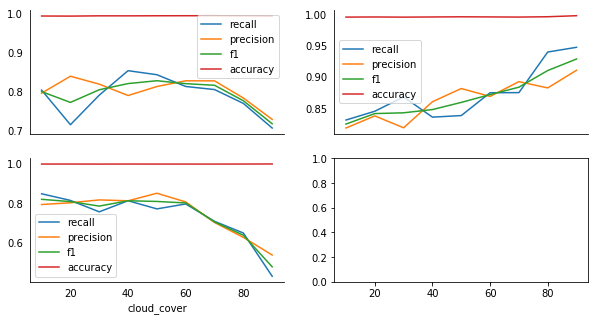

In [116]:
columns = 2
    
# Create list of axes
fig, axes = plt.subplots(nrows = int(len(valMetricsList) / columns + 1), ncols = columns, 
                         sharex = True, figsize = (10,5), squeeze = False)

axes_list = [item for sublist in axes for item in sublist] 

for i in range(len(valMetricsList)):
    ax = axes_list.pop(0) # Pop each axis out then put data into it
    valMetricsList[i].plot(ax = ax, x='cloud_cover', y=['recall', 'precision','f1','accuracy']) 
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)